Physics 215 Mini-project of Team **BOT**
* **B**adua, Mark Louise
* **O**idem, John Rommel
* **T**uquero, Richelle Jade$^*$

$^*$Implementation using QuantumOptics package.

In [1]:
using Pkg;
Pkg.activate(".")
Pkg.add("QuantumOptics")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")

Pkg.update()
Pkg.status()

  Activating project at `~/Desktop/Physics 215/Submission/Mini`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Project.toml`
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Project.toml`
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Project.toml`
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Project.toml`
  No Changes to `~/Desktop/Physics 215/Submission/Mini/Manifest.toml`


Status `~/Desktop/Physics 215/Submission/Mini/Project.toml`
  [b964fa9f] LaTeXStrings v1.3.0
  [91a5bcdd] Plots v1.36.6
  [438e738f] PyCall v1.94.1
  [d330b81b] PyPlot v2.11.0
  [6e0679c1] QuantumOptics v1.0.8


# Implementing the Quantum System using QuantumOptics

In this mini-project, we aim to simulate a one-dimensional closed quantum system with a Harmonic trap. The Hamiltonian simulated is
\begin{equation}\label{1}
\hat{H} = \frac{\hat{p}^2}{2m}+\frac{m\omega^2\hat{x}^2}{2}
\end{equation}
where $\hat{x}$ ($\hat{p}$) is the position (momentum) operator, and $\omega$ is the strength of the trap. In our discussion and simulation, we let the constant $\hbar$ to be 1.

We first implement the given Hamiltonian using the ``QuantumOptics`` package in Julia by [Krämer et al. (2018)](https://www.sciencedirect.com/science/article/abs/pii/S0010465518300328). Do note that for us to simulate a quantum system, we must first define the operators, bases, and set up the Hamiltonian. We can simulate both closed and open quantum systems. However, in this project, we will only be focusing on closed systems. One advantage of the ``QuantumOptics`` package is that it takes into account the Hilbert space where the operators and basis are. Another advantage of the package is that it is entirely written in Julia and is open-source.
The documentation of the library can be found in [QuantumOptics.jl documentation](https://docs.qojulia.org/).


In [2]:
using QuantumOptics  # For quantum system simulation
using Plots # For plotting
using LaTeXStrings # For LaTeX

First we determine the basis states for the position and momentum space using a given system parameters. These bases are specified to assign the Hilbert space of the system where the bases are present to avoid combining bases present in different Hilbert space. By using the ``PositionBasis`` and ``MomentumBasis``, we instruct that these bases should be calculated in real and momentum space, respectively. Note that we include both the position and momentum bases since we plan on having the algorithm use a Fourier transform. Afterwards, we define an operator in Julia. Note that an operator in Julia refers to the coefficients $A_{ij}$ of the abstract operator
\begin{equation}
A = \sum_{ij} A_{ij} |{u_i}\rangle\langle v_j|.
\end{equation}

In [3]:
# System Parameters
m = 1.0
ω = 2   # Strength of trapping potential

# Range for position
xmin = -4
xmax = 4
Npoints = 100;

In [4]:
# Basis
b_x = PositionBasis(xmin, xmax, Npoints);
b_p = MomentumBasis(b_x);

# operators
x = position(b_x);
p = momentum(b_p);

We want to utilize the fast Fourier transformation to simulate the system. We do this by implementing the function ``transform()``. This lets us change between the real and momentum space of our system by converting the position to momentum operator and vice versa. This comes from the idea that the momentum operator is just the Fourier transform of the position operator. Note that if we only focus on the real or momentum space, the calculations will scale $N^2$ for $N$ dimension. 

The function ``dagger(x)`` returns the Hermitian conjugate of ``x`` or by transforming the ket state as bra state.

In [5]:
px = transform(b_p, b_x) # position to momentum
xp = dagger(px)

FFTOperators(dim=100x100)
  basis left:  Position(xmin=-4, xmax=4, N=100)
  basis right: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=100)

Then, we proceed on defining our Hamiltonian by using Lazy Operators. The Lazy operators let's conduct an operation with a different order. For example, the ``LazyProduct(A,B,C)`` simplifies $A*(B*C)$ which is useful for terms like $ \mathrm{IFFT}*(D*(\mathrm{FFT}*\psi))$. Notice that the right basis for ($\mathrm{FFT}*\psi$) is now the momentum basis. This will be used to the kinetic energy part of the Hamiltonian. Hence, the Hamiltonian is a LazySum of the LazyProduct kinetic energy and the potential energy.

In [6]:
K = LazyProduct(xp, p^2/2m, px)
V = ω^2*x^2*m/2
H = LazySum(K, V)

LazySum(dim=100x100)
  basis: Position(xmin=-4, xmax=4, N=100)
  operators: 2

Next, we define the initial state as a Gaussian function using the function ``gaussianstate(x, p, sigma)`` where the Gaussian state is initially at ``x`` for real space, and ``p`` for the momentum space with width ``sigma``. The ``gaussianstate(x0, p0, sigma)``, where ``sigma`` is $\sigma$, is given by
\begin{equation}
\Psi_0(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}}e^{ip_0\left(x-\frac{x_0}{2}\right)-\frac{(x-x_0)^2}{2\sigma^2}}.
\end{equation}
Note that to show the time evolution of $\Psi$, we chose to not use the analytic initial state or the ground state. We do this by shifting the initial state away from the center of the harmonic trap.

In [7]:
x0 = 2 
p0 = 0
sigma = (1/m/ω)^(1/2)
psi0 = gaussianstate(b_x, x0, p0, sigma);

To get a better look of the initial state, we plot the probability distribution of the initial gaussian state and the harmonic trap potential.

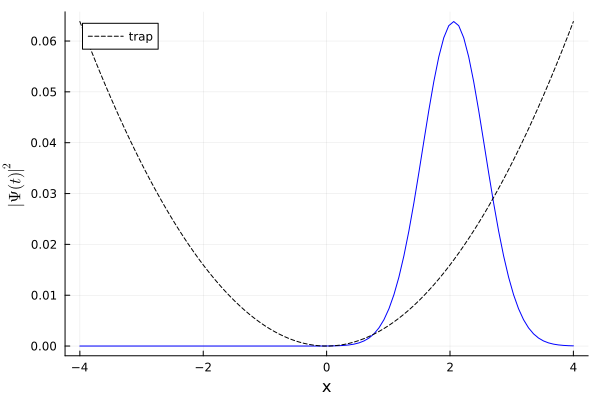

In [8]:
x_points = [xmin:(xmax-xmin)/(Npoints-1):xmax;]
n =abs.(psi0.data).^2
V0 = (ω^2*x_points.^2*m/2)/maximum(ω^2*x_points.^2*m/2)*maximum(abs.(psi0.data).^2)
p0 = plot(x_points, n, lc=:blue, label = false)
p0 = plot!(x_points,V0, lc=:black, linestyle = :dash, xlabel ="x", ylabel = L"| \Psi(t) |^2", label = "trap" )
display(p0)

Finally, we solve for the time evolution of the Schroedinger equation with a harmonic trap for a closed quantum system using the function in the QuantumOptics package ``timeevolution.schroedinger(t, psi0, H)``. Note that ``t`` is the time interval for the simulation, ``psi0`` is the initial state, and ``H`` is the Hamiltonian. The function solves the Schroedinger equation as defined below
\begin{gather}
i\hbar \frac{d}{dt}|\Psi(t)\rangle = H|\Psi(t)\rangle\\
i\hbar \frac{d}{dt}\langle\Psi(t)| = H\langle\Psi(t)|.
\end{gather}
One of the two possible implementations is chosen by Julia depending on the initial state.

In [9]:
time = [0:0.1:5;]
t, psi_t = timeevolution.schroedinger(time, psi0, H);

Then we animate to show the evolution of $\Psi(t)$ to confirm that the simulation worked. Moreover, we also showed the probability distribution $|\Psi(t)|^2$. We note that from the simulations, the distribution of $\Psi(t)$ mainly remains inside the trap, and is moving back and forth instead of moving outside.

┌ Info: Saved animation to /Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/time_evol.gif
└ @ Plots /Users/richellejadetuquero/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/time_evol.gif")
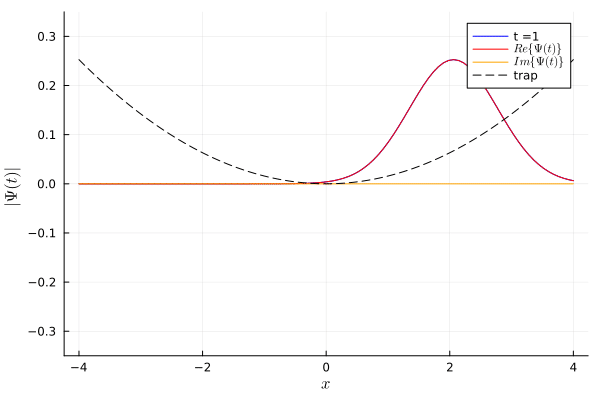

In [10]:
V1 = (ω^2*x_points.^2*m/2)/maximum(ω^2*x_points.^2*m/2)*maximum(abs.(psi0.data)) # Just for plotting the potential

pt = @animate for i=1:length(time)
    psi = psi_t[i]
    plot(x_points,abs.(psi.data) , lc=:blue, label = "t =$(i)",
        yaxis=("y", (-0.35, 0.35)), legend =:topright);
    plot!(x_points, real.(psi.data), lc=:red, label = L"Re\{ \Psi(t) \}",
        legend =:topright);
    plot!(x_points, imag.(psi.data), lc=:orange, label = L"Im\{ \Psi(t) \}",
        legend =:topright);
    plot!(x_points,V1, lc=:black, linestyle = :dash, xlabel =L"x", ylabel = L"| \Psi(t) |" , label = "trap", legend =:topright);

end
gif(pt, "time_evol.gif", fps = 10)

┌ Info: Saved animation to /Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/time_evol_sq.gif
└ @ Plots /Users/richellejadetuquero/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/time_evol_sq.gif")
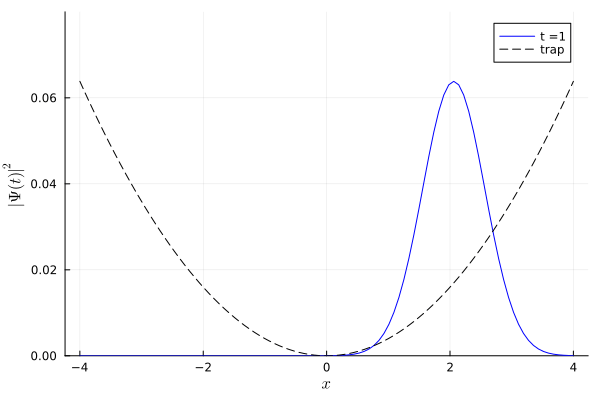

In [11]:
ptsq = @animate for i=1:length(time)
    psi = psi_t[i]
    n .= abs.(psi.data).^2
    plot(x_points,n , lc=:blue, label = "t =$(i)",
        yaxis=("y", (0, 0.08)), legend =:topright);
    plot!(x_points, V0, lc=:black, linestyle = :dash, xlabel =L"x", ylabel = L"| \Psi(t) |^2" , label = "trap", legend =:topright);

end
gif(ptsq, "time_evol_sq.gif", fps = 10)

To show that using the ground state would result to a steady state. We implement the same process using the ground state as the initial state. Note that the ground state or the exact solution for the Hamiltonian in Eq. \eqref{1} is
\begin{equation}
\Psi_0(x) = \frac{\sqrt{m\omega}}{\pi^{1/4}}e^{-\frac{m\omega x^2}{2}}.
\end{equation}

In [12]:
x0 = 0
p0 = 0
sigma = (1/m/ω)^(1/2)
psi0 = gaussianstate(b_x, x0, p0, sigma);
#psi0 = (m*ω/pi*ħ)^(1/4)*exp(-m*ω*x^2/2/ħ)

┌ Info: Saved animation to /Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/ground.gif
└ @ Plots /Users/richellejadetuquero/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/Users/richellejadetuquero/Desktop/Physics 215/Submission/Mini/ground.gif")
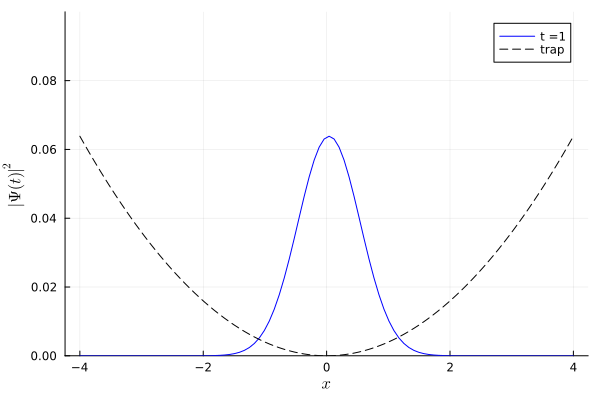

In [13]:
time = [0:0.1:5;]
t, psi_t = timeevolution.schroedinger(time, psi0, H);

pt = @animate for i=1:length(time)
    psi = psi_t[i]
    n .= abs.(psi.data).^2
    plot(x_points, n, lc=:blue, label = "t =$(i)",
        yaxis=("y", (0, 0.1)), legend =:topright);
    plot!(x_points,V0, lc=:black, linestyle = :dash, xlabel =L"x", ylabel = L"| \Psi(t) |^2" , label = "trap", legend =:topright);

end
gif(pt, "ground.gif", fps = 10)

From the implementation above, we define a function called as ``quant_ho`` which will solve the Schroedinger equation. This will be used in comparing the implementation using ``QuantumOptics`` package, and the split-step method.

In [14]:
function quant_ho( xmin, xmax, Npoints, m, ω, x0, p0, sigma, time )
    b_x = PositionBasis(xmin, xmax, Npoints);
    b_p = MomentumBasis(b_x);
    x = position(b_x);
    p = momentum(b_p);
    px = transform(b_p, b_x);
    xp = dagger(px);
    K = LazyProduct(xp, p^2/2m, px);
    V = ω^2*x^2*m/2;
    H = LazySum(K, V);
    psi0 = gaussianstate(b_position, x0, p0, sigma);
    t, psi_t = timeevolution.schroedinger(time, psi0, H);
    return t, psi_t;
end

quant_ho (generic function with 1 method)

**Reference**


[1] S. Krämer, D. Plankensteiner, L. Ostermann and H. Ritsch. QuantumOptics. jl: A Julia framework for simulating open quantum systems Comp. Phys. Comm. 227, 109-116 (2018)